In [1]:
import decimal

import pandas as pd
from cleaning import create_demand
import pyomo.environ as pyo
import pyomo
from pandas import DataFrame
import decimal

Lightning Network nodes can have multiple type of connections to be used.
Specifically, every node can be an hidden node - thus leveraging privacy
preserving communication protocols like Tor or I2P - or can use a clearnet connection,
with a standard IPv4 or IPv6 (or both) address.

In order to assign the "connection type" feature to each node, the following mapping
has been implemented:

- 1 if the node uses a privacy preserving protocol, eg it works as an hidden service;
- 2 if the node is a clearned with an IPv4 or IPv6 address;
- 3 if the node uses both connection typologies (eg both clearnet and onion)
 
Note that the score is independent from the number of addresses of each kind.
Thus if a node where to
have both an IPv4 and IPv6, the score would be 2 despite the support to two clearnet protocols.

The goal of this second scenario is to compute the shortest path with minimum cost between two nodes,
considering that privacy preserving nodes are, on average, more prone to higher latency, thus
causing payment failures and thus increasing the payment time.

In order to reproduce this scenario, we assign a penalization to the usage of channels that have a
connection type different from 3, which is the connection type associated with a wider range
of communication protocols and thus is likely to be associated with lower latency or less connection issues.

##### Alternative formulation

Setup the problem considering a constraint such that the address code has to be at least 2, meaning that we avoid nodes who have an onion only connection because they are associated to higher latency.

# Data import

In [2]:
nodes = pd.read_pickle("../../data/original/nodes.pkl")
channels = pd.read_pickle("../../data/original/channels.pkl")

In [3]:
def drop_not_mapped(df_nodes: DataFrame, df_channels: DataFrame) -> DataFrame:
    """
    Drop channels that have at least one peer not appearing in the nodes dataframe.
    :param df_nodes: nodes dataframe
    :param df_channels: channels dataframe
    :return: filtered channels dataframe containing only the channels
    whose peers partecipants both appear in the nodes dataframe
    """
    df_channels = df_channels[
        df_channels.loc[:, "node1_pub"].isin(df_nodes.index) &
        df_channels.loc[:, "node2_pub"].isin(df_nodes.index)
        ]
    return df_channels


def drop_missing_addresses(df_nodes: DataFrame) -> DataFrame:
    """
    Drop the nodes that have an unknown address type (which is 0).
    :param df_nodes: nodes dataframe
    :return: nodes dataframe without the nodes with address ==0
    """
    return df_nodes.loc[df_nodes.loc[:, "addresses"] != 0, :]


#channels = drop_not_mapped(nodes, channels)
nodes = drop_missing_addresses(nodes)

## Modeling

In [4]:
pyomo.common.timing.report_timing()

In [5]:
# Multiplication to set the same base unit for all computations
channels["capacity"] = channels["capacity"] * 1000000
channels["base_fee"] = channels["base_fee"] * 1000000

In [6]:
model = pyo.ConcreteModel(name="Min cost flow problem")
model.NODES = pyo.Set(initialize=nodes.index)
model.CHANNELS = pyo.Set(initialize=[(channels.loc[i, "node1_pub"], channels.loc[i, "node2_pub"]) for i in channels.index])

           0 seconds to construct Block ConcreteModel; 1 index total
        0.02 seconds to construct Set NODES; 1 index total
        0.18 seconds to construct Set CHANNELS; 1 index total


In [7]:
transaction_amount = 500000
nodes = create_demand(nodes, transaction_amount,
                      source="02b4098c3116124c0c4105295d3d2e65927d46e98e248d84cb6119da57e4ae31e3",destination="0202f00d5f5c91a3c79113851b162c2b75f2cbd9fb2378fb4a4ce92d5ba1e63e08")

Transaction of 500000 sats.
Sender: VeniceForever
Receiver: ShatSat412.


In [8]:
model.x = pyo.Var(model.CHANNELS, domain=pyo.Binary)
model.a = pyo.Var(model.CHANNELS, domain=pyo.NonNegativeReals, bounds=(0, max(nodes["demand"])))

        0.11 seconds to construct Var x; 89898 indices total
        0.13 seconds to construct Var a; 89898 indices total


In [9]:
channels.reset_index(inplace=True)
channels.set_index(["node1_pub", "node2_pub"], inplace=True)
channels.sort_index(inplace=True)

### Objective function

$$
min \sum_{i \in E} ^{} amount_i \times feerate_{i} + x_{i} \times basefee_{i} + x_{i} \times \frac{1}{(min(addresses_{node1_{i}}, addresses_{node2_{i}}))^4}
$$

Note that here we need to handle also the situation in which a node has only one channel, thus
its pubkey appears only as node1_pub (or node2_pub). Thus we need an exception handling when looking
for the minimum between the two addresses scores.
Note also that we consider the minimum between the two addresses scores because we want to penalize
the lower scores. Since we are minimizing the objective function, we assign a 1/min_score as a penalization coefficient

In [10]:
# The following code adds a column to the channels dataframe which contains the min score of addresses for each channel
channels.loc[:, "addresses"] = 0.0001
for i in channels.index:
    try:
        channels.at[i, "addresses"] = min([nodes.loc[i[0], "addresses"], nodes.loc[i[1], "addresses"]])
    except KeyError:
        try:
            channels.at[i, "addresses"] = nodes.loc[i[0], "addresses"]
        except KeyError:
            try:
                channels.at[i, "addresses"] = nodes.loc[i[1], "addresses"]
            except:
                pass


In [11]:
def objective_function(model: pyo.ConcreteModel):
    return sum(
        model.a[i] * channels.loc[i, "rate_fee"] +
        model.x[i] * channels.loc[i, "base_fee"] +
        model.x[i] * 1/(channels.loc[i, "addresses"])**4
        for i in model.CHANNELS)

#def objective_function(model: pyo.ConcreteModel):
#    """
#    Note that here we need to handle also the situation in which a node has only one channel, thus
#    its pubkey appears only as node1_pub (or node2_pub). Thus we need an exception handling when looking
#    for the minimum between the two addresses scores.
#    Note also that we consider the minimum between the two addresses scores because we want to penalize
#    the lower scores. Since we are minimizing the objective function, we assign a 1/min_score as a penalization coefficient
#    """
#    return sum(
#        model.a[i] * channels.loc[i, "rate_fee"] +
#        model.x[i] * channels.loc[i, "base_fee"] +
#        model.x[i] * (
#            1 / min(
#                (nodes.loc[i[0], "addresses"], nodes.loc[i[1], "addresses"])#,
#                #default=float('inf')
#            )
#            if (
#                   i[0] in nodes.index and i[1] in nodes.index and
#                   pd.notnull(nodes.loc[i[0], "addresses"]) and
#                   pd.notnull(nodes.loc[i[1], "addresses"])
#            )
#            else
#            (
#                nodes.loc[i[0], "addresses"] if pd.notnull(nodes.loc[i[0], "addresses"]) else (
#                    nodes.loc[i[1], "addresses"] if pd.notnull
#                else 0.0001
#                )
#            )
#        )
#        for i in model.CHANNELS
#    )


model.totalCost = pyo.Objective(rule=objective_function(model), sense=pyo.minimize)

           0 seconds to construct Objective totalCost; 1 index total


### Constraints

#### Symmetric channel flow rule

This constraint enforces the symmetry between the number of channel incoming and outgoing from an intermediary node (excluding source and destination nodes)

$$
\sum_{(i,n) \in E} x_{i,n} = \sum_{(n,j) \in E} x_{n,j} \text{ } \forall n \in V \bigwedge i \ne \{n, s, d\}
$$

where $s$ is the source node, with a negative demand and $d$ is the destination node, with positive demand.

In [12]:
s = nodes[nodes["demand"] < 0].index.values
d = nodes[nodes["demand"] > 0].index.values
intermediaries = [(i, j) for i, j in channels.index if i != s and j != d]

In [13]:
def number_channels_rule(model: pyo.ConcreteModel, n):
    incoming = [model.x[(i, j)] for i, j in intermediaries if j == n]
    outgoing = [model.x[(i, j)] for i, j in intermediaries if i == n]
    return sum(incoming) == sum(outgoing)

model.NumberChannelsConstraint = pyo.Constraint(model.NODES, rule=number_channels_rule, name="Number channels constraint")

       46.35 seconds to construct Constraint NumberChannelsConstraint; 11312 indices total


#### Capacity constraint

$$amount_{i,j} \le capacity_{i,j} \times x_{i,j} \text{ } \forall (i,j) \in E$$

In [14]:
def capacity_constraint(model: pyo.ConcreteModel, a, b):
    return model.a[(a, b)] <= channels.loc[(a, b), "capacity"] * model.x[(a, b)]

model.CapacityConstraint = pyo.Constraint(model.CHANNELS, rule=capacity_constraint, name="Capacity constraint")

        4.67 seconds to construct Constraint CapacityConstraint; 89898 indices total


#### Flow balance constraint

$$\sum_{(s,i) \in E} amount_{s,i} - \sum_{(i,t) \in E} amount_{i,d} = b_i \text{ } \forall i \in V$$

where $s$ is the source node, $d$ is the destination node, $i$ is every intermediary node


In [15]:
channels.reset_index(inplace=True)
channels.set_index("channel_id", inplace=True)

def flow_balance_constraint(model: pyo.ConcreteModel, n: str):
    InFlow = sum(model.a[(channels.loc[a, "node1_pub"], channels.loc[a, "node2_pub"])] for a in nodes.loc[n, 'incoming_channels'])
    OutFlow = sum(model.a[(channels.loc[a, "node1_pub"], channels.loc[a, "node2_pub"])] for a in nodes.loc[n, 'outgoing_channels'])
    return  OutFlow + nodes.loc[n, "demand"] == InFlow

model.FlowBalanceConstraint = pyo.Constraint(model.NODES, rule=flow_balance_constraint, name="Flow balance constrain")

channels.reset_index(inplace=True)
channels.set_index(["node1_pub", "node2_pub"], inplace=True)
channels.sort_index(inplace=True) 

        2.84 seconds to construct Constraint FlowBalanceConstraint; 11312 indices total


#### Avoid Onion Nodes constraint

$$

$$

## Solving the model

In [16]:
from pyomo.common.tempfiles import TempfileManager
#TempfileManager.tempdir = "/home/filippo/repositories/LN-pathfinding"

In [17]:
opt = pyo.SolverFactory('cbc')
#opt = pyo.SolverFactory('/opt/ibm/ILOG/CPLEX_Studio_Community2212/cplex/bin/x86-64_linux/cplex')
results = opt.solve(model, tee=True, keepfiles=True)

if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
    print('\nOptimal solution found')
elif results.solver.termination_condition == pyo.TerminationCondition.feasible:
    print('\nFeasible but not proven optimal solution found')
elif results.solver.termination_condition == pyo.TerminationCondition.infeasible:
    raise Exception("The model is infeasible")
else:
    print('\nSolver Status: ',  results.solver.status)
    raise Exception(results.solver.status)

print('\nObject function value = ', model.Objective())


           0 seconds to construct Var ONE_VAR_CONSTANT; 1 index total
      [    2.07] Generated LP representation
Solver log file: '/tmp/tmp6ee4cdp5.cbc.log'
Solver solution file: '/tmp/tmp5f47rq45.pyomo.soln'
Solver problem files: ('/tmp/tmp5f47rq45.pyomo.lp',)
Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: May  9 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmp5f47rq45.pyomo.lp -stat=1 -solve -solu /tmp/tmp5f47rq45.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 96086 (-16436) rows, 168772 (-11024) columns and 479168 (-54664) elements
Statistics for presolved model
Original problem has 89898 integers (89898 of which binary)
Presolved problem has 84386 integers (84386 of which binary)
==== 6414 zero objective 4291 different
==== absolute objective values 4291 different
==== for integers 0 zero objective 1391 different
==== for integers absolute objective values 1391 different
===== end objective coun

In [18]:
from decimal import Decimal
pd.set_option('display.max_colwidth', 10000000000000000000000000000000000000000000000000000)
DF_channels = pd.DataFrame()
c = 0
for index, value in model.a.extract_values().items():
    if value > 0.1:
        DF_channels.loc[c, "source"] = index[0]
        DF_channels.loc[c, "destination"] = index[1]
        try:
            DF_channels.loc[c, "source-alias"] = nodes.loc[index[0], "alias"]
        except KeyError:
            print("Source alias not found in nodes database: placeholder inserted")
            DF_channels.loc[c, "source-alias"] = "source-alias"
            pass
        try:
            DF_channels.loc[c, "destination-alias"] = nodes.loc[index[1], "alias"]
        except KeyError:
            print("Destination alias not found in nodes database: placeholder inserted")
            DF_channels.loc[c, "destination-alias"] = "destination-alias"
            pass
        DF_channels.loc[c, "capacity"] = Decimal(channels.loc[index, "capacity"]/1000000)
        DF_channels.loc[c, "amount"] = Decimal(value/1000000)
        DF_channels.loc[c, "base_fee"] = Decimal(channels.loc[(index[0], index[1]), "base_fee"]/1000000)
        DF_channels.loc[c, "rate_fee"] = channels.loc[(index[0], index[1]), "rate_fee"]
        DF_channels.loc[c, "addresses"] = channels.loc[(index[0], index[1]), "addresses"]
        #DF_channels.loc[c, "used_fl"] = channels.loc[]
        c += 1

DF_channels_pos = DF_channels[DF_channels["amount"]!=0]

Source alias not found in nodes database: placeholder inserted
Destination alias not found in nodes database: placeholder inserted


In [19]:
DF_channels[DF_channels["amount"]> DF_channels["capacity"]]

,source,destination,source-alias,destination-alias,capacity,amount,base_fee,rate_fee,addresses


In [20]:
DF_fixed = pd.DataFrame()
c = 0
for index, value in model.x.extract_values().items():
    if value != 0:
        DF_fixed.loc[c, "source"] = index[0]
        DF_fixed.loc[c, "destination"] = index[1]
        DF_fixed.loc[c, "used"] = Decimal(value)
        c += 1

DF_fixed_pos = DF_fixed[DF_fixed["used"]!=0]
DF_fixed_pos

,source,destination,used
0,0208d92b2d406094d794b2a6a512f585dbbdee810a870283b9c5bafc4fec8ac0aa,034f3f792988c43f41c65a839acdfa48647204bb99aca7de426f7c80b0dcf7a4a6,1
1,026be7f5f2f6649cb9eca52009bb855fc036814da1b703310041966a1912763d91,03e81689bfd18d0accb28d720ed222209b1a5f2c6825308772beac75b1fe35d491,1
2,02b4098c3116124c0c4105295d3d2e65927d46e98e248d84cb6119da57e4ae31e3,0208d92b2d406094d794b2a6a512f585dbbdee810a870283b9c5bafc4fec8ac0aa,1
3,02bc400b9df471549c1a2071a61be27460e9726d3399370671514dd8356606bd81,037f66e84e38fc2787d578599dfe1fcb7b71f9de4fb1e453c5ab85c05f5ce8c2e3,1
4,02dbdd45505ca50500f78b0c52e73747415147e0c5ca28d72450d18884c54771d8,03641a88d80a2a85bbecd770577aca9b5495616e9fef63d66ef2631b7cca1d395d,1
5,02ddb472c8edf0624dec5544507b705aae67d42a6cc2db133ba7e843fd5ce90135,026be7f5f2f6649cb9eca52009bb855fc036814da1b703310041966a1912763d91,1
6,02f0c7b731ca40a285d7c12aa1c5c7c7caa4598d3d6d34904c3714cd0d47852640,03c8e5f583585cac1de2b7503a6ccd3c12ba477cfd139cd4905be504c2f48e86bd,1
7,02f1a8c87607f415c8f22c00593002775941dea48869ce23096af27b0cfdcc0b69,0208d92b2d406094d794b2a6a512f585dbbdee810a870283b9c5bafc4fec8ac0aa,1
8,034f3f792988c43f41c65a839acdfa48647204bb99aca7de426f7c80b0dcf7a4a6,02ddb472c8edf0624dec5544507b705aae67d42a6cc2db133ba7e843fd5ce90135,1
9,03641a88d80a2a85bbecd770577aca9b5495616e9fef63d66ef2631b7cca1d395d,02bc400b9df471549c1a2071a61be27460e9726d3399370671514dd8356606bd81,1


### All data about channels on path

In [21]:
intersection = DF_fixed_pos.merge(DF_channels_pos, on=["source", "destination"], how="outer")
final = intersection[intersection["amount"]>0]

### Compute transaction costs

In [22]:
final

,source,destination,used,source-alias,destination-alias,capacity,amount,base_fee,rate_fee,addresses
0,0208d92b2d406094d794b2a6a512f585dbbdee810a870283b9c5bafc4fec8ac0aa,034f3f792988c43f41c65a839acdfa48647204bb99aca7de426f7c80b0dcf7a4a6,1,Eprahs,hexagon,1000000,500000,1,0.0000,1.0
1,026be7f5f2f6649cb9eca52009bb855fc036814da1b703310041966a1912763d91,03e81689bfd18d0accb28d720ed222209b1a5f2c6825308772beac75b1fe35d491,1,Sats4Fun,Rust-eze (now BoltTrustiC),2000000,500000,0,0.0000,3.0
2,02b4098c3116124c0c4105295d3d2e65927d46e98e248d84cb6119da57e4ae31e3,0208d92b2d406094d794b2a6a512f585dbbdee810a870283b9c5bafc4fec8ac0aa,1,VeniceForever,Eprahs,1500000,500000,1,0.0000,1.0
3,02bc400b9df471549c1a2071a61be27460e9726d3399370671514dd8356606bd81,037f66e84e38fc2787d578599dfe1fcb7b71f9de4fb1e453c5ab85c05f5ce8c2e3,1,Aldebaran,HODLmeTight,10000000,500000,0,0.0000,3.0
4,02dbdd45505ca50500f78b0c52e73747415147e0c5ca28d72450d18884c54771d8,03641a88d80a2a85bbecd770577aca9b5495616e9fef63d66ef2631b7cca1d395d,1,source-alias,Nodelou🐈,5000000,500000,0,0.0000,3.0
5,02ddb472c8edf0624dec5544507b705aae67d42a6cc2db133ba7e843fd5ce90135,026be7f5f2f6649cb9eca52009bb855fc036814da1b703310041966a1912763d91,1,AfricaFreeRouting,Sats4Fun,2000000,500000,0,0.0000,3.0
6,02f0c7b731ca40a285d7c12aa1c5c7c7caa4598d3d6d34904c3714cd0d47852640,03c8e5f583585cac1de2b7503a6ccd3c12ba477cfd139cd4905be504c2f48e86bd,1,Henwen 🐷,Strike,10000000,500000,0,0.0000,2.0
8,034f3f792988c43f41c65a839acdfa48647204bb99aca7de426f7c80b0dcf7a4a6,02ddb472c8edf0624dec5544507b705aae67d42a6cc2db133ba7e843fd5ce90135,1,hexagon,AfricaFreeRouting,2000000,500000,0,0.0000,1.0
9,03641a88d80a2a85bbecd770577aca9b5495616e9fef63d66ef2631b7cca1d395d,02bc400b9df471549c1a2071a61be27460e9726d3399370671514dd8356606bd81,1,Nodelou🐈,Aldebaran,5000000,500000,0,0.0000,3.0
10,0378a5312ca36773971df43f833b571d024fd7d5d216fbdf7e241b710714ef1be1,03a1f3afd646d77bdaf545cceaf079bab6057eae52c6319b63b5803d0989d6a72f,1,OneKey,destination-alias,200000000,500000,0,0.0000,2.0


In [23]:
%%capture --no-stdout
final["amount"] = final["amount"].astype(float)
final["rate_fee"] = final["rate_fee"].astype(float)
final["base_fee"] = final["base_fee"].astype(float)

In [24]:
total_transaction_cost = sum(final["amount"]*final["rate_fee"] + final["base_fee"])
perc_cost = (total_transaction_cost * 100) / transaction_amount
print(f"Transacting {transaction_amount} sats costs {total_transaction_cost} ({perc_cost}% of transaction amount)")

Transacting 500000 sats costs 53.0 (0.0106% of transaction amount)


In [25]:
print("Solver Status: ",  results.solver[0]["System time"])

Solver Status:  76.34


In [26]:

%%capture --no-stderr


/home/filippo/repositories/LN-pathfinding/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128008 (\N{CAT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/filippo/repositories/LN-pathfinding/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128055 (\N{PIG FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


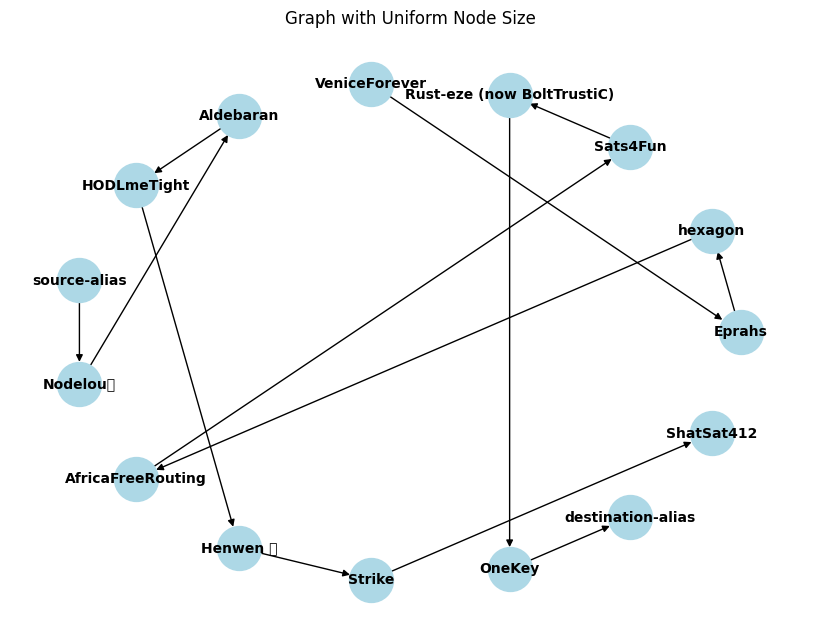

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

# edges list construction
edges_df = final[["source-alias", "destination-alias"]]

G = nx.from_pandas_edgelist(edges_df, "source-alias", "destination-alias", create_using=nx.DiGraph())

plt.figure(figsize=(8, 6))
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=10, font_color='black',
        font_weight='bold', arrows=True)
plt.title("Graph with Uniform Node Size")
plt.show()

In [28]:
for i in nx.strongly_connected_components(G):
    print(i)

{'destination-alias'}
{'OneKey'}
{'Rust-eze (now BoltTrustiC)'}
{'Sats4Fun'}
{'AfricaFreeRouting'}
{'hexagon'}
{'Eprahs'}
{'VeniceForever'}
{'ShatSat412'}
{'Strike'}
{'Henwen 🐷'}
{'HODLmeTight'}
{'Aldebaran'}
{'Nodelou🐈'}
{'source-alias'}


In [29]:
#from collections import Counter
##results = [tuple(i) for i in DF_channels_pos[["source-alias", "destination-alias"]].to_numpy()]
#results = [tuple(i) for i in final[["source-alias", "destination-alias"]].to_numpy()]
#unwrap = [e for i in results for e in i]
#extremes = [j for j in unwrap if Counter(unwrap)[j] == 1]
#def return_source(l: list):
#    if l[0] in [i for i, j in results]:
#        return l[0]
#    else: 
#        return l[1]
#sequence = []        
#source = return_source(extremes)
#sequence.append(source)
#while len(sequence) <= len(results):
#    for i,j in results:
#        if i == sequence[-1]:
#            sequence.append(j)
#for i in sequence:
#    print("⬇️", i)